In [30]:
import pandas as pd
import numpy as np
import shapely

square_line_path = '../data/line.csv'

In [3]:
df_square_line = pd.read_csv(square_line_path)

df_square_line.head()

,SQUAREID,LINESET,NR_UBICAZIONI
0,155,DG1031221,4
1,272,DG1031221,72
2,273,DG1031221,21
3,276,DG1003117,34
4,277,DG1003117,3


In [4]:
df_square_line['SQUAREID'].nunique()

2020

In [5]:
df_square_line['LINESET'].nunique()

200

In [6]:
from collections import defaultdict

square_to_lineset = defaultdict(list)
lineset_to_square = defaultdict(list)

for i in range(len(df_square_line)):
    square, line, nums = df_square_line.iloc[i,:]
    
    square_to_lineset[square].append(line)
    lineset_to_square[line].append((square,nums))

In [7]:
# Set the ratio of each line to each grid

lineset_ratio = dict()

for key, vals in lineset_to_square.items():
    set_names = [item[0] for item in vals]
    set_vals = np.array([item[1] for item in vals])
    set_ratios = set_vals / np.sum(set_vals)
    
    lineset_ratio[key] = {name: ratio for name, ratio in zip(set_names, set_ratios)}

In [8]:
unique_linsets = df_square_line['LINESET'].unique()

In [9]:
unique_sqaures = df_square_line['SQUAREID'].unique()

In [36]:
# Calculate total current of grid
# Input current of all lines in time t
# Output current of all grids in time t

def calculate_current_grid(line_current):
    
    d = {square: 0 for square in unique_sqaures}
    for line, value in line_current:
        # ratio is the ratio of line for each grid
        ratio = lineset_ratio[line]
        for square, r in ratio.items():
            # Using the absolute value
            d[square] += abs(value) * r
            
    return list(d.values())

In [11]:
# Load line electricity consumption

df_line_usage = pd.read_csv('../data/SET-nov-2013.csv',names=['LINESET','Time','Current'])

In [12]:
df_line_usage.head()

,LINESET,Time,Current
0,DG1000420,2013-11-01 00:00,37.439999
1,DG1000420,2013-11-01 00:10,37.439999
2,DG1000420,2013-11-01 00:20,36.000000
3,DG1000420,2013-11-01 00:30,35.279999
4,DG1000420,2013-11-01 00:40,35.279999


In [46]:
unique_time_series = df_line_usage['Time'].unique()

def generate_time_series():
    # Ruturn numpy array
    df = lineset_current.set_index(['Time'])
    
    Grid_current = np.zeros((len(unique_time_series),len(unique_sqaures)))
    
    for i, time in enumerate(unique_time_series):
        lineset_current = df.loc[time].as_matrix()
        Grid_current[i] = calculate_current_grid(lineset_current)
        
    return Grid_current

Grid_current = generate_time_series()

In [52]:
df_Grid_current = pd.DataFrame(Grid_current,columns=unique_sqaures)

In [57]:
df_Grid_current['Time'] = unique_time_series
df_Grid_current = df_Grid_current.set_index(['Time'])

In [83]:
df_Grid_current.to_csv('../data/Nov_Grid_Current.csv')

In [64]:
# The last number seems to have some problems

df_line_usage.set_index(['Time']).loc[unique_time_series[-1]].as_matrix()

array([['DG1012320', 22.200001],
       ['DG1012321', 28.674999],
       ['DG1012327', 0.0]], dtype=object)

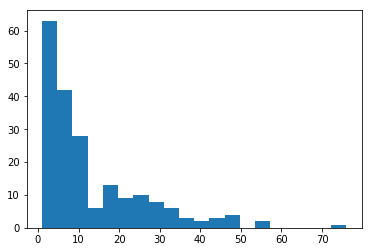

In [28]:
import matplotlib.pyplot as plt

line_nums = [len(pair) for pair in lineset_to_square.values()]

plt.hist(line_nums, bins=20)
plt.show()

In [1]:
import geopandas as gpd

states = gpd.read_file('../data/trentino-grid.geojson')

In [166]:
unique_time_series[120]

'2013-11-01 20:00'

In [168]:
# Choose several time in a day

time_idx = [0, 60, 90, 120]

# '2013-11-01 00'
# '2013-11-01 10'
# '2013-11-01 15'
# '2013-11-01 20'

In [111]:
# Vasulize electricity location
import matplotlib.pyplot as plt

def visualize(states,current_data,title):
    
    centers = states.set_index('cellId').loc[current_data.index]['geometry'].centroid.values
    values = current_data.values / np.max(current_data.values)
    states.plot(figsize=(10,6), alpha=0.1)

    for val, center in zip(values, centers):
        x,y = list(center.coords)[0]
        plt.scatter(x,y,alpha=val,color='red')

    plt.title(title, fontsize=15)
    plt.show()


In [ ]:
# Visualize in different tiem
for idx in time_idx:
    current_data = df_Grid_current.loc[unique_time_series[idx]]
    visualize(current_data,'{}'.format(unique_time_series[idx]))

### ANALYZE

In [25]:
grid_current_df = pd.read_csv('../data/Nov_Grid_Current.csv', parse_dates=['Time'])

In [26]:
grid_current_df['Time'].max() - grid_current_df['Time'].min()

Timedelta('29 days 23:50:00')

In [145]:
states['centroid'] = states['geometry'].apply(lambda point: point.centroid)

states['xy'] = states['centroid'].apply(lambda c: list(c.coords)[0])

In [11]:
# Select longitude[11.0 - 11.2], latitude[46.0, 46.2]

In [32]:
rec = shapely.geometry.Polygon([(11.0,46.0),(11.2,46.0),(11.2,46.2),(11.0,46.2)])

In [37]:
states['WinthRec?'] = states['centroid'].apply(lambda centroid: centroid.within(rec))

rec_df = states[states['WinthRec?'] == True]

In [115]:
# Check if the id consistant. It seems no problem here
col_list = list(grid_current_df.columns[1:])
cellId = [str(id_) for id_ in np.unique(states['cellId'].values)]

np.where([id_ not in cellId for id_ in col_list])

(array([], dtype=int64),)

In [133]:
cellId_within = list(rec_df.cellId)

In [158]:
idxes = [0, 60, 90, 120]

def visualize(loc_df,val_df,idx):
    
    centers, values = [], []
    for id_ in cellId_within:
        if str(id_) in col_list:
            centers.append(states.loc[int(id_)].xy)
            values.append(val_df[int(id_)][idx])
        
    loc_df.plot(figsize=(10,6), alpha=0.1)
    for val, center in zip(values, centers):
        if shapely.geometry.Point(center).within(rec):
            x,y = list(center.coords)[0]
            plt.scatter(x,y,alpha=val,color='red')

    plt.title(idx, fontsize=15)
    plt.show()

# Visualize in different tiem
for idx in idxes:
    visualize(rec_df, grid_current_df, idx)

KeyError: 4379